In [16]:
#1 IMPORTS

import numpy as np
import pandas as pd
from statsbombpy import sb
from mplsoccer import Pitch
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

In [17]:
#2 LOAD EURO24 STATSBOMB 360 DATA 

# Identify EURO 2024 in the statsbomb competitions dataset
competitions = sb.competitions()
competitions_24 = competitions[competitions['season_name'] == '2024']

# View all matches from EURO 2024
sb.matches(competition_id=55, season_id=282)

# Set path to local 360 data folder
three_sixty_path = 'C:/Users/conno/Documents/Education/GIS/Applied Research Project/open-data/data/three-sixty/'

# Load and filter all EURO 2024 matches
matches_df = sb.matches(competition_id=55, season_id=282)

# Create a datetime column for chronological sorting
matches_df['datetime'] = pd.to_datetime(matches_df['match_date'] + ' ' + matches_df['kick_off'])

# Keep only completed matches with 360 data
matches_df = matches_df[
    (matches_df['match_status'] == 'available') & 
    (~matches_df['last_updated_360'].isna())
]

# Sort by kickoff time
matches_df = matches_df.sort_values('datetime').reset_index(drop=True)

# Extract the match_id list in chronological order
match_ids = matches_df['match_id'].tolist()

In [18]:
#3 ASSIGN PITCH ZONES

def assign_pitch_zones(df):
    def get_zone(x, y):
        if pd.isna(x) or pd.isna(y):
            return None

        # Defensive third
        if 0 <= x < 40:
            if 18 <= y <= 62:
                return 'Defensive central'
            else:
                return 'Defensive wide'

        # Middle third
        elif 40 <= x < 80:
            if 18 <= y <= 62:
                return 'Midfield central'
            else:
                return 'Midfield wide'

        # Attacking third
        elif 80 <= x <= 120:
            if 30 <= y <= 50 and 80 <= x < 102:
                return 'Attacking central low'
            elif y > 62 or y < 18:
                return 'Attacking wide'
            elif (18 <= y < 30) or (50 < y <= 62):
                return 'Half space'
            elif 30 <= y <= 50 and x >= 102:
                return 'Attacking central high'

        return None

    df['end_zone'] = df.apply(
        lambda row: get_zone(row['pass_end_x_aligned'], row['pass_end_y']), axis=1
    )

# Assign the pass start and end 1/3 zones 
def assign_pitch_thirds(df):
    def get_third(x):
        if pd.isna(x):
            return None
        elif x < 40:
            return 'Defensive Third'
        elif x < 80:
            return 'Middle Third'
        else:
            return 'Attacking Third'

    # Start third from event location
    df['start_third'] = df['location_x_aligned'].apply(get_third)

    # End third from pass end or carry end
    df['end_third'] = df['pass_end_x_aligned'].apply(get_third)

In [27]:
#4 SUMMARY DATAFRAME

def generate_team_summary(df, match_id):
    team_rows = []
    teams = df['team_name'].dropna().unique()

    for team in teams:
        try:
            team_df = df[df['team_name'] == team]
            opponent = [t for t in teams if t != team][0]
            total_minutes = team_df['minute'].max()
            
            # Goals scored
            goals_scored = team_df[
                (team_df['type'] == 'Shot') &
                (team_df['shot_outcome'] == 'Goal')
            ].shape[0]
            goals_per_90 = round((goals_scored / total_minutes) * 90, 2)
            
            # Goals conceded
            opponent_df = df[df['team_name'] == opponent]
            goals_conceded = opponent_df[
                (opponent_df['type'] == 'Shot') &
                (opponent_df['shot_outcome'] == 'Goal')
            ].shape[0]
            goals_conceded_per_90 = round((goals_conceded / total_minutes) * 90, 2)

            # xG 
            xg_sum = team_df['shot_statsbomb_xg'].dropna().sum()
            xg_per_90 = round((xg_sum / total_minutes) * 90, 2)
            
            # xGA 
            xga_sum = opponent_df['shot_statsbomb_xg'].dropna().sum()
            xga_per_90 = round((xga_sum / total_minutes) * 90, 2)

            if pd.isna(total_minutes) or total_minutes == 0:
                raise ValueError("Invalid total minutes")

            # Carries 
            carries = team_df[team_df['type'] == 'Carry'].shape[0]
            carries_per_90 = round((carries / total_minutes) * 90, 2)

            # Counterattacks
            counter_possessions = team_df[
                (team_df['play_pattern'] == 'From Counter') &
                (team_df['possession'].notna())
            ]['possession'].nunique()
            counterattacks_per_90 = round((counter_possessions / total_minutes) * 90, 2)

            # Passes
            pass_df = team_df[team_df['type'] == 'Pass'].copy()
            team_passes = pass_df.shape[0]

            # Pass zone proportions 
            zone_counts = pass_df['end_zone'].value_counts(normalize=True).to_dict()
            all_zones = [
                'Defensive central',
                'Defensive wide',
                'Midfield central',
                'Midfield wide',
                'Attacking central low',
                'Attacking central high',
                'Attacking wide',
                'Half space',
                'None'
            ]
            zone_metrics = {
                f'zone_pct_{zone.lower().replace(" ", "_")}': round(zone_counts.get(zone, 0) * 100, 2)
                for zone in all_zones
            }

            # Median pass length by third
            median_lengths = pass_df.groupby('start_third')['pass_length'].median().to_dict()
            median_def = round(median_lengths.get('Defensive Third', 0), 2)
            median_mid = round(median_lengths.get('Middle Third', 0), 2)
            median_att = round(median_lengths.get('Attacking Third', 0), 2)

            # Pass direction 
            forward_passes = pass_df[
                (pass_df['pass_angle'].notna()) &
                (pass_df['pass_angle'] >= -0.79) & 
                (pass_df['pass_angle'] <= 0.79)
            ].shape[0]
            sideways_passes = pass_df[
                (pass_df['pass_angle'].notna()) &
                (((pass_df['pass_angle'] > 0.79) & (pass_df['pass_angle'] <= 2.36)) |
                 ((pass_df['pass_angle'] < -0.79) & (pass_df['pass_angle'] >= -2.36)))
            ].shape[0]
            backward_passes = pass_df[
                (pass_df['pass_angle'].notna()) &
                ((pass_df['pass_angle'] > 2.36) | (pass_df['pass_angle'] < -2.36))
            ].shape[0]

            forward_pct = round((forward_passes / team_passes) * 100, 2) if team_passes > 0 else 0
            sideways_pct = round((sideways_passes / team_passes) * 100, 2) if team_passes > 0 else 0
            backward_pct = round((backward_passes / team_passes) * 100, 2) if team_passes > 0 else 0

            # Summary metrics
            total_passes_in_match = df[df['type'] == 'Pass'].shape[0]
            passes_per_90 = round((team_passes / total_minutes) * 90, 2)
            possession_pct = round((team_passes / total_passes_in_match) * 100, 2) if total_passes_in_match > 0 else 0
            successful_passes = pass_df['pass_outcome'].isna().sum()
            pass_accuracy_pct = round((successful_passes / team_passes) * 100, 2) if team_passes > 0 else 0
            aerial_passes = pass_df[pass_df['pass_height'] == 'High Pass'].shape[0]
            aerial_pass_pct = round((aerial_passes / team_passes) * 100, 2) if team_passes > 0 else 0

            # Out-of-possession events 
            oop_event_types = [
                '50/50', 'Block', 'Clearance', 'Dribbled Past', 'Duel',
                'Foul Committed', 'Interception', 'Pressure'
            ]
            oop_events = team_df[team_df['type'].isin(oop_event_types)].shape[0]

            # Out-of-possession events with freeze_frame
            oop_ff_df = team_df[
                (team_df['type'].isin(oop_event_types)) &
                (team_df['freeze_frame'].notna())
            ].copy()
            
            # High Press (%) - Count defending players in attacking third
            def count_high_pressers(freeze, team_name):
                try:
                    return sum(
                        1 for player in freeze
                        if player.get('position', {}).get('name') != 'Goalkeeper'
                        and player.get('teammate') is True
                        and player.get('location') is not None
                        and player['location'][0] > 80  # Attacking third
                    )
                except Exception:
                    return 0
            
            oop_ff_df['high_press_count'] = oop_ff_df['freeze_frame'].apply(lambda ff: count_high_pressers(ff, team))
            
            # Keep events where at least 4 teammates are pressing in attacking third
            high_press_events = oop_ff_df[oop_ff_df['high_press_count'] >= 4].shape[0]
            
            # Calculate percentage
            high_press_pct = round((high_press_events / oop_events) * 100, 2) if oop_events > 0 else 0

            # Mid Block (%) — Count defending players in middle third
            oop_ff_df = team_df[
                (team_df['type'].isin(oop_event_types)) &
                (team_df['freeze_frame'].notna())
            ].copy()
            
            def count_mid_block_players(freeze_frame):
                try:
                    return sum(
                        1 for player in freeze_frame
                        if player.get('teammate') is True
                        and player.get('position', {}).get('name') != 'Goalkeeper'
                        and isinstance(player.get('location'), list)
                        and 40 <= player['location'][0] < 80
                    )
                except:
                    return 0
            
            oop_ff_df['mid_block_count'] = oop_ff_df['freeze_frame'].apply(count_mid_block_players)
            
            # Count how many events had 4 or more teammates in the middle third
            mid_block_events = oop_ff_df[oop_ff_df['mid_block_count'] >= 4].shape[0]
            
            # Mid block % of all out-of-possession events
            mid_block_pct = round((mid_block_events / oop_events) * 100, 2) if oop_events > 0 else 0

            # Low Block (%) — Count defending players in defensive third
            def count_low_block_players(freeze_frame):
                try:
                    return sum(
                        1 for player in freeze_frame
                        if player.get('teammate') is True
                        and player.get('position', {}).get('name') != 'Goalkeeper'
                        and isinstance(player.get('location'), list)
                        and 0 <= player['location'][0] < 40  # Defensive third
                    )
                except:
                    return 0
            
            oop_ff_df['low_block_count'] = oop_ff_df['freeze_frame'].apply(count_low_block_players)

            # Count how many events had 6 or more teammates in the defensive third
            low_block_events = oop_ff_df[oop_ff_df['low_block_count'] >= 6].shape[0]
            
            # Low block % of all out-of-possession events
            low_block_pct = round((low_block_events / oop_events) * 100, 2) if oop_events > 0 else 0
            
            # Counterpress events
            counterpress_events = team_df[
                (team_df['type'].isin(oop_event_types)) &
                (team_df['counterpress'] == True)
            ].shape[0]

            # Counterpress %
            counterpress_pct = round((counterpress_events / oop_events) * 100, 2) if oop_events > 0 else 0
            
            # Regroup % (defending opponent counterattacks) 
            # Get all out-of-possession possession IDs for the team
            oop_possession_ids = team_df[team_df['type'].isin(oop_event_types)]['possession'].dropna().unique()
            
            # Get the opponent's events with play_pattern == 'From Counter'
            opponent_counter_possessions = opponent_df[
                (opponent_df['play_pattern'] == 'From Counter') &
                (opponent_df['possession'].notna())
            ]['possession'].unique()
            
            # Find intersections of possession IDs
            regroup_possessions = np.intersect1d(oop_possession_ids, opponent_counter_possessions)
            
            # Count how many OOP events the team had in those possessions
            regroup_events = team_df[
                (team_df['type'].isin(oop_event_types)) &
                (team_df['possession'].isin(regroup_possessions))
            ].shape[0]
            
            # Calculate percentage
            regroup_pct = round((regroup_events / oop_events) * 100, 2) if oop_events > 0 else 0

            # Summary row
            team_rows.append({
                'match_id': match_id,
                'team': team,
                'opponent': opponent,
                'goals_per_90': goals_per_90,
                'xg_per_90': xg_per_90,
                'goals_conceded_per_90': goals_conceded_per_90,
                'xga_per_90': xga_per_90,
                'carries_per_90': carries_per_90,
                'counterattacks_per_90': counterattacks_per_90,
                'passes_per_90': passes_per_90,
                'possession_pct': possession_pct,
                'pass_accuracy_pct': pass_accuracy_pct,
                'aerial_pass_pct': aerial_pass_pct,
                'forward_pass_pct': forward_pct,
                'sideways_pass_pct': sideways_pct,
                'backward_pass_pct': backward_pct,
                'median_pass_length_def': median_def,
                'median_pass_length_mid': median_mid,
                'median_pass_length_att': median_att,
                'counterpress_pct': counterpress_pct,
                'regroup_pct': regroup_pct,
                'high_press_pct': high_press_pct,
                'mid_block_pct': mid_block_pct,
                'low_block_pct': low_block_pct,
                **zone_metrics
            })

            print(f"✅ Row added for {team} in match {match_id}")

        except Exception as e:
            print(f"⚠️ Error for {team} in match {match_id}: {e}")

    return pd.DataFrame(team_rows)

In [29]:
#5 LOOP THROUGH MATCHES

all_team_summaries = []

for idx, match_id in enumerate(match_ids[:]):  # limit if testing
    print(f"\n📊 Processing match {match_id}...")

    try:
        # Load event and 360 data
        match_events_df = sb.events(match_id=match_id)
        match_360_df = pd.read_json(f'{three_sixty_path}{match_id}.json')

        # Print match info
        match_info = matches_df[matches_df['match_id'] == match_id].iloc[0]
        home_team = match_info['home_team']
        away_team = match_info['away_team']
        print(f"\"Match {idx + 1}: {home_team} v {away_team}\"")

        # Merge event and 360 data
        df = pd.merge(
            left=match_events_df,
            right=match_360_df,
            left_on='id',
            right_on='event_uuid',
            how='left'
        )
        print(f"✅ Merged event & 360 data → shape: {df.shape}")
        print(f"👉 Rows with 360 data: {df['visible_area'].notna().sum()}")

        # Assign team_name
        df['team_name'] = df['team']
        print("🏷️'team_name' assigned")

        # Filter event types
        relevant_event_types = [
            'Pass', 'Carry', 'Pressure', 'Duel', 'Shot', 'Ball Receipt',
            'Miscontrol', 'Dispossessed', '50/50', 'Block', 'Clearance',
            'Foul Committed', 'Interception', 'Dribbled Past'
        ]
        df = df[df['type'].isin(relevant_event_types)]
        print(f"🧹 Filtered relevant event types → shape: {df.shape}")

        # Count types
        type_counts = df['type'].value_counts().to_frame(name='count')
        type_counts.index.name = 'type'
        print("🔍 Events by type:")
        print(type_counts)

        # Build x/y coords
        df['location_x'] = df['location'].apply(lambda x: x[0] if isinstance(x, list) and len(x) == 2 else np.nan)
        df['location_y'] = df['location'].apply(lambda x: x[1] if isinstance(x, list) and len(x) == 2 else np.nan)
        df['pass_end_x'] = df['pass_end_location'].apply(lambda x: x[0] if isinstance(x, list) and len(x) == 2 else np.nan)
        df['pass_end_y'] = df['pass_end_location'].apply(lambda x: x[1] if isinstance(x, list) and len(x) == 2 else np.nan)

        # Assign pitch zones and thirds using standard coordinates
        df['location_x_aligned'] = df['location_x']
        df['pass_end_x_aligned'] = df['pass_end_x']
        
        assign_pitch_zones(df)
        assign_pitch_thirds(df)
        
        print("🗺️  Zones and thirds assigned (sample):")
        print(df[['team_name', 'type', 'end_zone', 'start_third', 'end_third']].dropna().head())

        team_summary_df = generate_team_summary(df, match_id)
        all_team_summaries.append(team_summary_df)
        print(f"📥 Added team summary for match {match_id}")

    except Exception as e:
        print(f"⚠️ Skipping match {match_id} due to error: {e}")

summary_df = pd.concat(all_team_summaries, ignore_index=True)
print("\n✅ Final summary dataframe (first 5 rows):")
display(summary_df)


📊 Processing match 3930158...
"Match 1: Germany v Scotland"
✅ Merged event & 360 data → shape: (3373, 94)
👉 Rows with 360 data: 3088
🏷️'team_name' assigned
🧹 Filtered relevant event types → shape: (2259, 95)
🔍 Events by type:
                count
type                 
Pass              999
Carry             773
Pressure          260
Duel               47
Block              35
Clearance          29
Miscontrol         25
Foul Committed     25
Shot               21
Dispossessed       14
Interception       12
Dribbled Past      11
50/50               8
🗺️  Zones and thirds assigned (sample):
   team_name  type               end_zone      start_third        end_third
6    Germany  Pass       Midfield central     Middle Third     Middle Third
7    Germany  Pass  Attacking central low     Middle Third  Attacking Third
8    Germany  Pass  Attacking central low  Attacking Third  Attacking Third
9   Scotland  Pass      Defensive central  Defensive Third  Defensive Third
10   Germany  Pass     

,match_id,team,opponent,goals_per_90,xg_per_90,goals_conceded_per_90,xga_per_90,carries_per_90,counterattacks_per_90,passes_per_90,possession_pct,pass_accuracy_pct,aerial_pass_pct,forward_pass_pct,sideways_pass_pct,backward_pass_pct,median_pass_length_def,median_pass_length_mid,median_pass_length_att,counterpress_pct,regroup_pct,high_press_pct,mid_block_pct,low_block_pct,zone_pct_defensive_central,zone_pct_defensive_wide,zone_pct_midfield_central,zone_pct_midfield_wide,zone_pct_attacking_central_low,zone_pct_attacking_central_high,zone_pct_attacking_wide,zone_pct_half_space,zone_pct_none
0,3930158,Germany,Scotland,4.89,1.80,0.00,0.06,571.30,5.87,708.26,72.47,91.85,9.94,22.51,60.22,17.27,18.93,14.42,13.49,20.10,1.01,28.64,39.20,13.07,6.77,2.21,37.85,18.23,4.70,3.18,16.16,10.91,0
1,3930158,Scotland,Germany,0.00,0.06,4.89,1.80,184.89,5.87,269.02,27.53,74.91,23.27,39.27,41.82,18.91,20.53,14.55,13.16,16.23,6.14,7.89,33.33,45.61,24.00,13.45,13.82,30.55,2.91,2.55,10.91,1.82,0
2,3930159,Hungary,Switzerland,0.94,1.03,2.81,1.96,308.44,2.81,453.75,49.59,79.55,23.55,29.96,54.96,15.08,20.85,16.91,16.51,11.79,1.14,11.79,44.49,33.84,15.70,10.33,19.42,29.55,1.65,4.75,13.64,4.96,0
3,3930159,Switzerland,Hungary,2.81,1.96,0.94,1.03,368.44,1.88,461.25,50.41,82.72,15.45,29.47,56.10,14.43,19.72,16.93,13.36,18.53,0.77,16.99,46.72,28.96,12.20,7.93,25.61,22.56,2.64,4.27,17.89,6.91,0
4,3930160,Croatia,Spain,0.00,2.38,2.87,1.50,438.51,0.00,534.26,53.24,86.56,12.90,25.99,55.20,18.82,19.24,14.87,13.77,17.42,0.00,13.81,52.85,23.12,17.20,9.50,30.29,25.09,2.33,2.15,8.78,4.66,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,3942752,Spain,France,1.89,0.41,0.95,0.81,449.05,2.84,513.47,57.97,87.27,13.47,27.49,52.40,20.11,19.48,17.59,14.47,17.81,2.74,17.35,28.31,31.96,14.58,8.67,24.91,24.35,2.40,3.32,14.76,7.01,0
98,3942819,England,Netherlands,1.89,1.19,0.95,0.39,515.37,0.95,588.32,58.31,90.18,11.92,22.22,61.67,16.10,24.11,17.88,14.89,24.24,3.79,28.03,34.09,25.76,11.11,4.83,33.98,23.19,2.58,2.09,13.37,8.86,0
99,3942819,Netherlands,England,0.95,0.39,1.89,1.19,346.74,0.95,420.63,41.69,88.74,11.26,27.70,57.66,14.64,21.12,18.16,16.28,20.00,0.59,7.06,30.00,38.82,23.65,6.76,27.70,19.14,1.80,2.70,12.84,5.41,0
100,3943043,England,Spain,0.98,0.71,1.96,1.75,262.17,2.93,316.96,35.33,78.40,20.99,36.42,49.38,14.20,24.19,16.59,13.17,15.93,2.59,12.59,30.74,32.96,18.21,8.33,21.30,21.60,5.25,3.40,14.20,7.72,0


In [30]:
# Export to Excel
summary_df.to_excel("euro2024_team_summary.xlsx", index=False)
print("✅ Data exported to 'euro2024_team_summary.xlsx'")

✅ Data exported to 'euro2024_team_summary.xlsx'


In [51]:
team_summary_avg = (
    summary_df
    .drop(columns=['match_id', 'goals_per_90', 'goals_conceded_per_90', 'xg_per_90', 'xga_per_90', 'zone_pct_none'])
    .groupby('team', as_index=False)
    .mean(numeric_only=True)
    .round(2)  # 👈 Rounds all numeric columns to 2 decimal places
)

display(team_summary_avg)

,team,carries_per_90,counterattacks_per_90,passes_per_90,possession_pct,pass_accuracy_pct,aerial_pass_pct,forward_pass_pct,sideways_pass_pct,backward_pass_pct,median_pass_length_def,median_pass_length_mid,median_pass_length_att,counterpress_pct,regroup_pct,high_press_pct,mid_block_pct,low_block_pct,zone_pct_defensive_central,zone_pct_defensive_wide,zone_pct_midfield_central,zone_pct_midfield_wide,zone_pct_attacking_central_low,zone_pct_attacking_central_high,zone_pct_attacking_wide,zone_pct_half_space
0,Albania,306.24,2.51,373.01,35.37,80.88,20.94,34.85,49.55,15.61,18.42,16.41,13.76,16.26,1.62,13.79,27.99,43.64,16.70,11.13,23.94,27.87,2.91,3.08,10.02,4.35
1,Austria,392.23,4.72,488.43,52.70,81.39,17.87,30.11,53.57,16.32,18.83,16.98,14.17,15.07,2.54,19.58,40.77,26.06,13.94,5.45,27.70,19.07,4.12,5.15,16.21,8.35
2,Belgium,451.53,2.16,527.91,55.07,85.08,13.46,27.78,56.43,15.78,21.04,18.39,14.46,17.90,0.70,21.15,34.06,30.95,18.95,8.69,21.35,22.63,3.15,2.78,13.54,8.91
3,Croatia,468.21,1.23,553.70,55.74,87.02,12.76,24.53,58.51,16.96,18.66,15.48,12.54,18.92,2.19,20.02,44.35,25.32,13.21,6.06,29.02,21.40,4.33,3.34,14.14,8.51
4,Czech Republic,263.84,4.10,350.67,40.40,72.12,30.58,36.95,50.80,12.25,21.88,20.68,15.83,17.56,2.39,18.25,28.72,37.85,14.30,7.15,19.08,20.40,3.50,7.75,18.50,9.33
5,Denmark,450.45,2.40,566.99,53.91,84.14,15.55,28.20,56.16,15.64,19.33,15.30,14.16,18.83,2.69,17.26,40.70,28.13,10.83,6.36,33.08,22.21,3.30,4.04,12.21,7.97
6,England,478.25,1.79,569.82,54.89,86.16,14.37,26.18,57.74,16.08,21.90,16.58,14.05,20.53,2.04,19.20,34.59,31.32,14.69,5.79,27.93,23.18,2.83,3.00,14.06,8.53
7,France,438.31,3.14,522.44,50.95,87.22,11.61,27.61,56.23,16.16,18.95,16.24,14.10,16.71,1.48,17.80,33.65,33.21,13.11,5.65,22.79,23.83,3.28,4.19,17.93,9.23
8,Georgia,278.19,3.36,339.39,34.18,78.50,20.94,35.46,49.77,14.77,20.34,14.68,13.85,16.94,1.40,10.17,20.89,55.27,16.06,14.74,21.86,28.20,1.99,3.34,9.27,4.55
9,Germany,540.64,3.23,623.01,62.75,88.20,12.97,27.08,55.66,17.27,18.17,15.06,13.98,22.42,1.59,22.37,37.83,26.93,10.89,5.86,31.71,19.18,4.88,4.30,13.90,9.27


In [58]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd

# 1. Select only numeric features
features_df = team_summary_avg.drop(columns=['team'])

# 2. Standardise the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_df)

# 3. Apply PCA
pca = PCA(n_components=None)
pca_features = pca.fit_transform(scaled_features)

# ✅ 4. Create a PCA DataFrame 
pca_df = pd.DataFrame(
    pca_features,
    columns=[f'PC{i+1}' for i in range(pca_features.shape[1])]
)

# ✅ 5. Add team names back — both dataframes must be reset
pca_df['team'] = team_summary_avg.reset_index(drop=True)['team']

# 6. Explained variance
explained_var = pd.Series(
    pca.explained_variance_ratio_,
    index=[f'PC{i+1}' for i in range(pca_features.shape[1])]
)

print("Explained variance ratio per component:")
print(explained_var)

# 7. Preview
display(pca_df.head())

Explained variance ratio per component:
PC1     4.464823e-01
PC2     1.454557e-01
PC3     9.286678e-02
PC4     7.299064e-02
PC5     4.860848e-02
PC6     4.541204e-02
PC7     4.110516e-02
PC8     2.646759e-02
PC9     2.435920e-02
PC10    1.720220e-02
PC11    1.071432e-02
PC12    9.516998e-03
PC13    5.085857e-03
PC14    4.325641e-03
PC15    3.103885e-03
PC16    2.508713e-03
PC17    1.628265e-03
PC18    1.222204e-03
PC19    4.456035e-04
PC20    2.678626e-04
PC21    2.225886e-04
PC22    7.377805e-06
PC23    5.743696e-07
PC24    7.210300e-35
dtype: float64


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,team
0,3.599836,-2.891223,1.111319,0.110179,0.097404,0.294255,-0.520756,-0.579863,-0.570117,0.631918,-0.858280,1.165348,-0.164192,-0.106311,-0.501949,0.135131,-0.084701,-0.029133,0.066768,0.010612,0.000976,-0.014270,-0.006163,4.245674e-17,Albania
1,-1.486214,2.927016,2.933498,0.547839,0.118548,-0.456453,-0.034564,-0.731284,0.132427,-0.214097,-0.426347,-0.370407,-0.369918,-0.149016,0.595526,-0.167363,-0.235849,-0.188746,0.044697,-0.091752,-0.050674,-0.017979,-0.004939,4.245674e-17,Austria
2,-1.542001,-0.038304,-1.464033,0.513128,-1.963754,0.445077,-1.034871,-0.525492,0.668486,1.384426,0.790649,0.200414,-0.372422,-0.468600,0.200007,-0.263770,0.137179,0.106126,-0.061276,-0.022515,0.128057,-0.004375,-0.001599,4.245674e-17,Belgium
3,-4.461506,-0.414552,1.081348,0.236084,1.566848,-0.825531,-0.921825,0.261130,1.592207,0.360183,0.328929,1.077016,0.292323,0.344199,0.038720,0.005779,-0.214742,0.024910,-0.090468,-0.100878,-0.038544,0.006518,0.004866,4.245674e-17,Croatia
4,4.126987,6.456081,-0.047521,-1.045126,-0.842870,1.358450,-0.295739,0.720243,-0.799460,-0.343536,-0.029215,0.735444,0.099299,0.287355,-0.068388,-0.021233,-0.094211,0.132533,-0.078272,0.019628,0.042146,-0.000547,0.001216,4.245674e-17,Czech Republic


In [59]:
import numpy as np

# Cumulative explained variance
cumulative_variance = explained_var.cumsum()

# Find the smallest number of components that explain ≥ 90% of the variance
n_components_90 = np.argmax(cumulative_variance >= 0.9) + 1  # +1 since index is 0-based

print(f"✅ Number of components to retain (≥90% variance): {n_components_90}")

✅ Number of components to retain (≥90% variance): 8


In [60]:
# Keep only the top N components
pca_reduced = pca_df.iloc[:, :n_components_90]  # just PC1 to PCn
pca_reduced['team'] = pca_df['team']  # add team back for reference

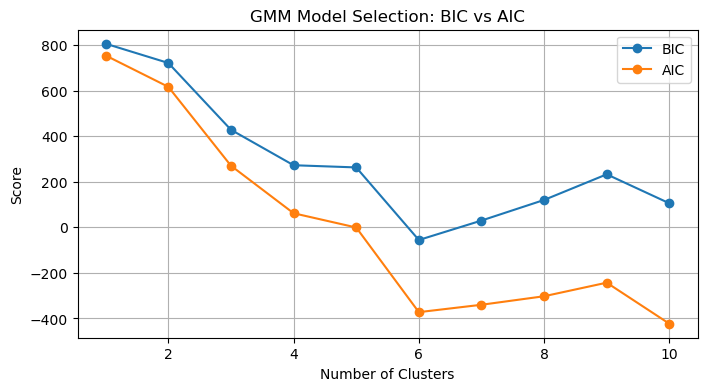

In [61]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

X = pca_reduced.drop(columns='team')

bic = []
aic = []
n_components_range = range(1, 11)

for n in n_components_range:
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(X)
    bic.append(gmm.bic(X))
    aic.append(gmm.aic(X))

# Plot BIC and AIC
plt.figure(figsize=(8, 4))
plt.plot(n_components_range, bic, label='BIC', marker='o')
plt.plot(n_components_range, aic, label='AIC', marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('GMM Model Selection: BIC vs AIC')
plt.legend()
plt.grid(True)
plt.show()

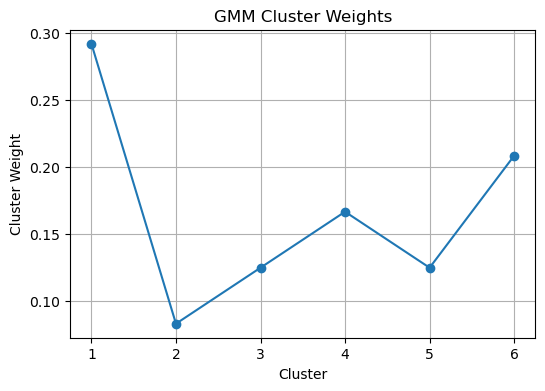

In [62]:
# Fit a GMM with the best number of clusters from BIC/AIC (or test a range)
best_n = 6  # or whatever seems best from your BIC/AIC plot
gmm_final = GaussianMixture(n_components=best_n, random_state=42)
gmm_final.fit(X)

# Plot cluster weights
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
plt.plot(range(1, best_n + 1), gmm_final.weights_, marker='o')
plt.xlabel('Cluster')
plt.ylabel('Cluster Weight')
plt.title('GMM Cluster Weights')
plt.grid(True)
plt.show()

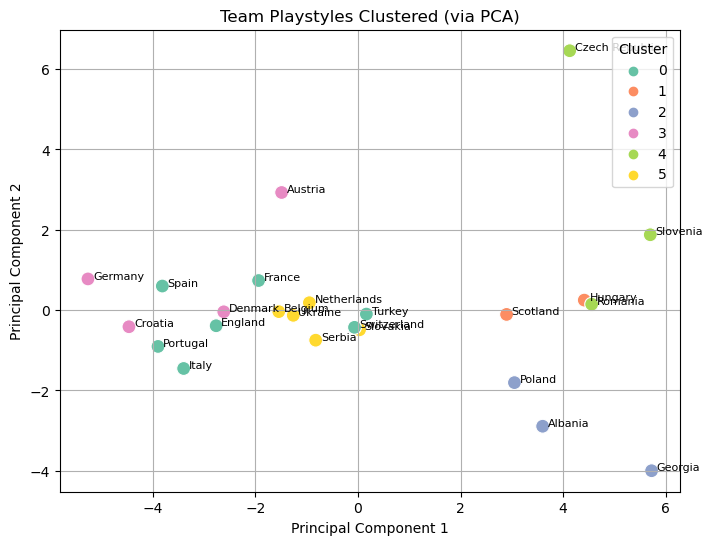

In [63]:
pca_reduced['cluster'] = gmm_final.predict(X)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=pca_reduced,
    x='PC1', y='PC2',
    hue='cluster',
    palette='Set2',
    s=100
)
for _, row in pca_reduced.iterrows():
    plt.text(row['PC1'] + 0.1, row['PC2'], row['team'], fontsize=8)

plt.title('Team Playstyles Clustered (via PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

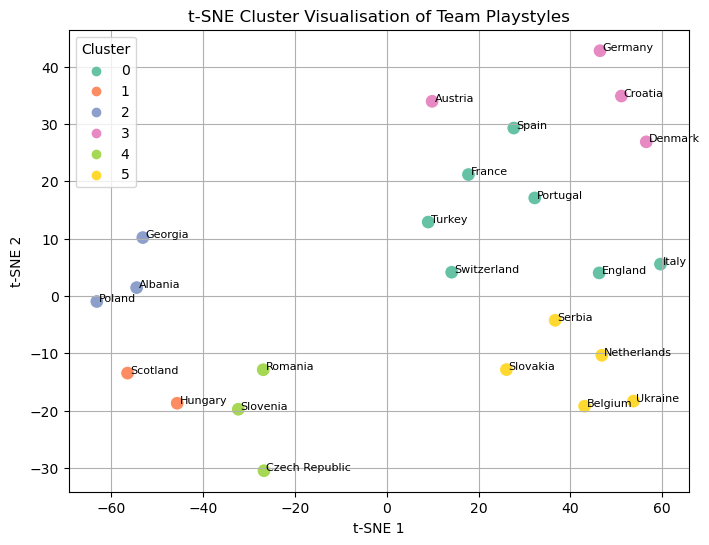

In [64]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=5)
tsne_features = tsne.fit_transform(X)

tsne_df = pd.DataFrame(tsne_features, columns=['TSNE1', 'TSNE2'])
tsne_df['team'] = pca_reduced['team']
tsne_df['cluster'] = pca_reduced['cluster']

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=tsne_df,
    x='TSNE1', y='TSNE2',
    hue='cluster',
    palette='Set2',
    s=100
)
for _, row in tsne_df.iterrows():
    plt.text(row['TSNE1'] + 0.5, row['TSNE2'], row['team'], fontsize=8)

plt.title('t-SNE Cluster Visualisation of Team Playstyles')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

In [67]:
# Combine cluster labels with original (non-standardised) features
clustered_df = team_summary_avg.copy()
clustered_df['cluster'] = pca_reduced['cluster']

# Group by cluster and calculate the mean of each feature
cluster_summary = clustered_df.groupby('cluster').mean(numeric_only=True).round(2)

# Display the summary
display(cluster_summary)


,carries_per_90,counterattacks_per_90,passes_per_90,possession_pct,pass_accuracy_pct,aerial_pass_pct,forward_pass_pct,sideways_pass_pct,backward_pass_pct,median_pass_length_def,median_pass_length_mid,median_pass_length_att,counterpress_pct,regroup_pct,high_press_pct,mid_block_pct,low_block_pct,zone_pct_defensive_central,zone_pct_defensive_wide,zone_pct_midfield_central,zone_pct_midfield_wide,zone_pct_attacking_central_low,zone_pct_attacking_central_high,zone_pct_attacking_wide,zone_pct_half_space
cluster,,,,,,,,,,,,,,,,,,,,,,,,,
0,459.71,2.36,547.52,54.35,85.88,13.68,27.75,55.83,16.42,19.49,16.22,14.27,19.33,1.28,19.86,33.15,32.25,13.19,7.12,25.81,23.36,2.80,3.65,15.75,8.33
1,273.92,3.00,382.31,42.63,77.03,24.60,34.15,49.75,16.10,20.86,16.16,16.07,14.10,2.22,13.49,40.08,35.74,18.14,10.12,21.17,25.52,2.27,4.66,12.58,5.54
2,298.70,3.34,364.06,36.86,79.91,19.66,34.88,50.25,14.88,18.60,15.35,13.51,16.21,1.99,12.33,26.32,46.90,17.02,12.10,22.01,27.18,2.43,3.34,10.89,5.03
3,462.88,2.90,558.03,56.28,85.19,14.79,27.48,55.97,16.55,18.75,15.70,13.71,18.81,2.25,19.81,40.91,26.61,12.22,5.93,30.38,20.46,4.16,4.21,14.12,8.52
4,241.22,2.69,327.76,37.02,72.52,29.96,37.80,48.70,13.51,22.98,18.47,14.82,16.90,1.51,14.59,30.62,41.45,13.04,9.38,20.75,23.88,2.89,5.20,16.14,8.71
5,403.85,1.82,496.66,51.80,83.79,16.11,29.45,54.82,15.73,20.84,17.44,14.76,18.90,0.88,17.65,35.94,31.52,17.97,7.31,26.49,21.36,2.51,3.40,13.28,7.68


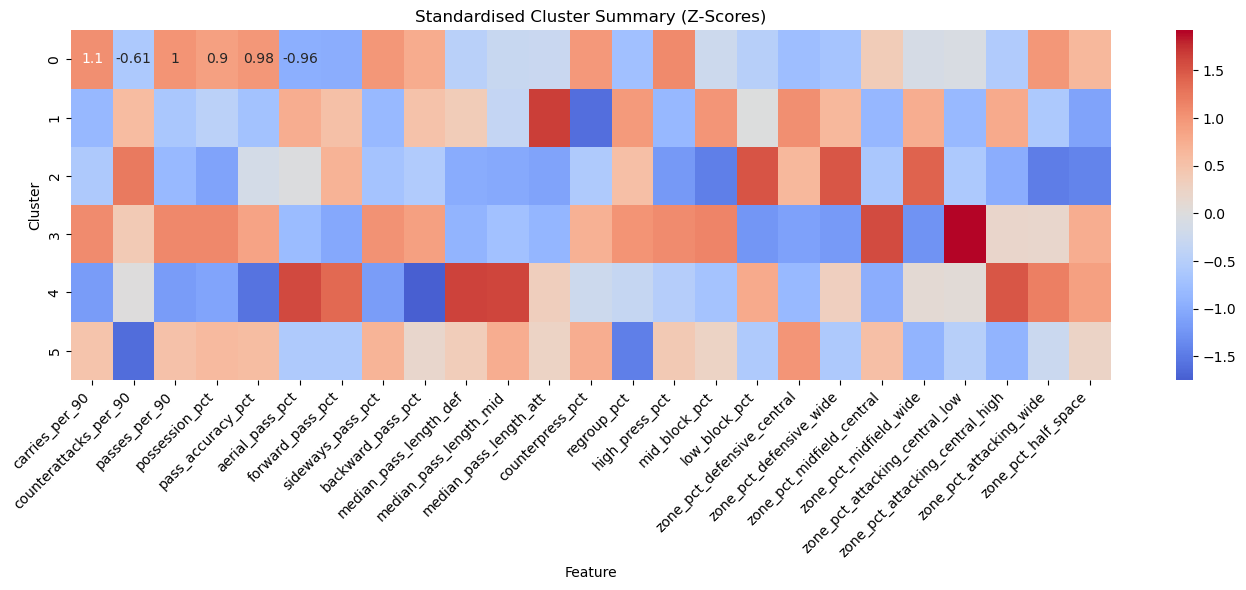

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

# Optional: Standardise the cluster means for visual comparison
standardised_summary = (cluster_summary - cluster_summary.mean()) / cluster_summary.std()

plt.figure(figsize=(14, 6))
sns.heatmap(standardised_summary, annot=True, cmap='coolwarm', center=0)
plt.title("Standardised Cluster Summary (Z-Scores)")
plt.xlabel("Feature")
plt.ylabel("Cluster")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [71]:
# Define cluster labels
cluster_labels = {
    0: "High Press, Short Passing, Wide Focus",
    1: "Direct Play, Minimal Pressing",
    2: "Low/Mid-Block Counterattackers",
    3: "Possession-Based, High Press & Attack centrally",
    4: "Direct, Low Block",
    5: "Possession-Based, Minimal Pressing"
}

# Apply labels to your PCA dataframe
pca_reduced['cluster_label'] = pca_reduced['cluster'].map(cluster_labels)

# Optionally merge labels into the original team summary dataframe
team_summary_labeled = team_summary_avg.merge(
    pca_reduced[['team', 'cluster', 'cluster_label']],
    on='team',
    how='left'
)

# Sort the dataframe by cluster (0 to 5)
team_summary_labeled_sorted = team_summary_labeled.sort_values(by='cluster').reset_index(drop=True)

# Display the sorted dataframe
display(team_summary_labeled_sorted[['team', 'cluster', 'cluster_label']])

,team,cluster,cluster_label
0,Italy,0,"High Press, Short Passing, Wide Focus"
1,Switzerland,0,"High Press, Short Passing, Wide Focus"
2,Spain,0,"High Press, Short Passing, Wide Focus"
3,Portugal,0,"High Press, Short Passing, Wide Focus"
4,England,0,"High Press, Short Passing, Wide Focus"
5,France,0,"High Press, Short Passing, Wide Focus"
6,Turkey,0,"High Press, Short Passing, Wide Focus"
7,Scotland,1,"Direct Play, Minimal Pressing"
8,Hungary,1,"Direct Play, Minimal Pressing"
9,Poland,2,Low/Mid-Block Counterattackers


In [72]:
# Recalculate KPI metrics per team
kpi_df = (
    summary_df
    .groupby('team', as_index=False)
    [['goals_per_90', 'goals_conceded_per_90', 'xg_per_90', 'xga_per_90']]
    .mean(numeric_only=True)
)

# Merge with cluster labels
merged_df = team_summary_labeled_sorted.merge(kpi_df, on='team')


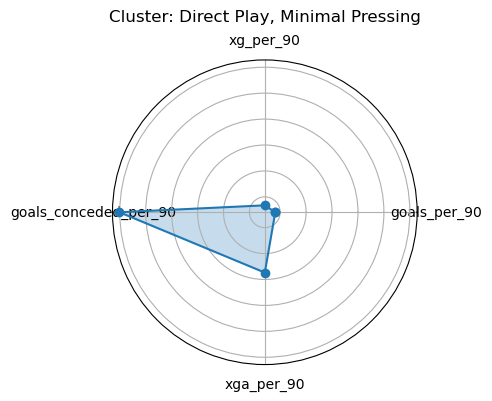

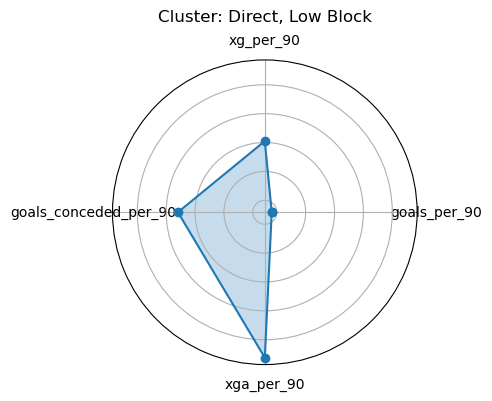

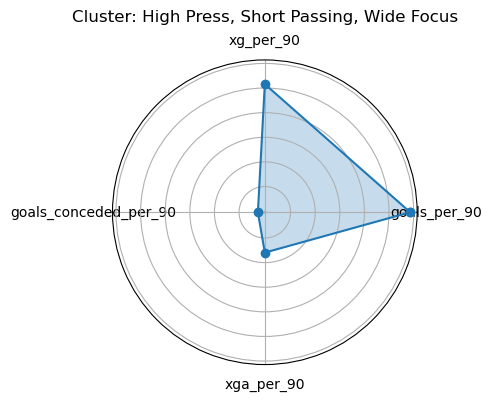

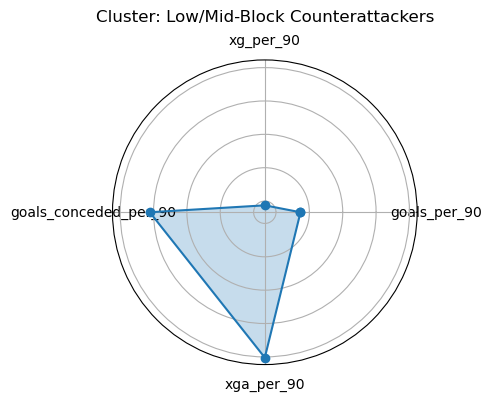

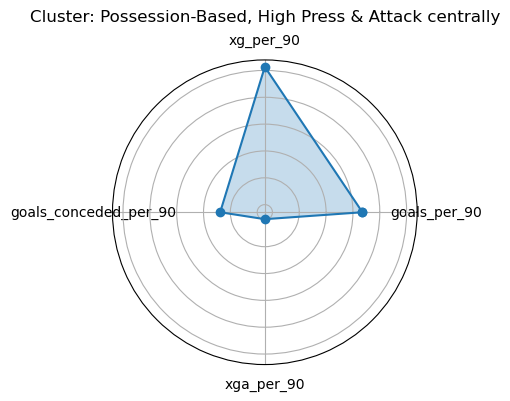

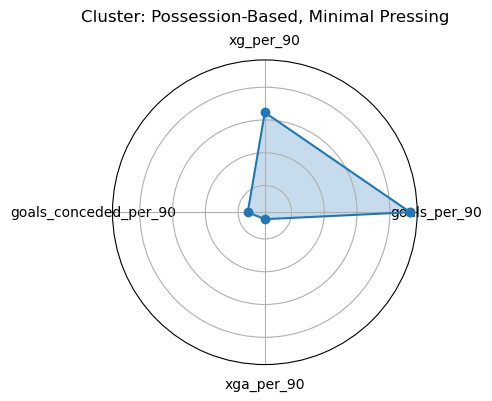

In [75]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Standardise KPI values
kpi_df = merged_df[['cluster_label', 'goals_per_90', 'xg_per_90', 'goals_conceded_per_90', 'xga_per_90']]
scaler = StandardScaler()
kpi_df_scaled = pd.DataFrame(scaler.fit_transform(kpi_df.drop(columns='cluster_label')), columns=kpi_df.columns[1:])
kpi_df_scaled['cluster_label'] = merged_df['cluster_label']

# Step 2: Get mean z-scores per cluster
cluster_kpi_means = kpi_df_scaled.groupby('cluster_label').mean()

# Step 3: Radar plot per cluster
labels = cluster_kpi_means.columns
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # complete the circle

for i, row in cluster_kpi_means.iterrows():
    values = row.tolist()
    values += values[:1]  # close the loop

    fig, ax = plt.subplots(figsize=(5, 5), subplot_kw=dict(polar=True))
    ax.plot(angles, values, marker='o')
    ax.fill(angles, values, alpha=0.25)
    ax.set_title(f"Cluster: {i}", y=1.1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    ax.set_yticklabels([])
    ax.grid(True)
    plt.tight_layout()
    plt.show()